# <center>Trabajo Práctico N°2 : Criticas Cinematograficas</center>

**Grupo:** N°28 - The Kingdom

**Alumnos**:


*   Jurgens, Cecilia Ines
*   Schipani, Martin Sebastian
*   Soto, Marylin Nicole

**Corrector:** Franco Mastelli

Todos los modelos y summits ingresados en kaggle fueron subidos a este [drive](https://drive.google.com/drive/folders/1-DGJCpWqsaQr9HeSF3--MXjqxYuMJX5g?usp=sharing).

---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
import string
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
nltk.download('omw-1.4')
nltk.download('snowball_data')

from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, make_scorer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from xgboost import XGBClassifier

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
#from keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences

from scipy.stats import uniform, randint

from nltk.stem.snowball import SpanishStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import joblib

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package snowball_data to /root/nltk_data...
[nltk_data]   Package snowball_data is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install Unidecode

from unidecode import unidecode

# Importacion de los Dataset

## Dataset Train

In [ ]:
dataset_train_original = pd.read_csv("/content/drive/MyDrive/Orga Datos - TP2/train.csv")
df_train = dataset_train_original.copy()
df_train.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


Realizamos un pequeño analisis del dataset y sus variables.

In [ ]:
df_train.shape

(50000, 3)

In [ ]:
df_train.dtypes

ID              int64
review_es      object
sentimiento    object
dtype: object

In [ ]:
df_train.sentimiento.value_counts()

positivo    25000
negativo    25000
Name: sentimiento, dtype: int64

In [ ]:
df_train.isna().sum()

ID             0
review_es      0
sentimiento    0
dtype: int64

## Dataset Test

In [ ]:
dataset_test_original = pd.read_csv("/content/drive/MyDrive/Orga Datos - TP2/test.csv")
df_test = dataset_test_original.copy()
df_test.head()

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."


Realizamos un pequeño analisis del dataset y sus variables.

In [ ]:
df_test.shape

(8599, 2)

In [ ]:
df_test.dtypes

ID            int64
review_es    object
dtype: object

In [ ]:
df_test.isna().sum()

ID           0
review_es    0
dtype: int64

## Funciones Auxiliares

In [ ]:
def imprimir_matriz_confusion(x, y):
  print(classification_report(x, y, digits = 5))
  tabla = confusion_matrix(x, y)
  sns.heatmap(tabla, cmap = 'cubehelix', annot = True, fmt = 'g')
  plt.xlabel('Predicho')
  plt.ylabel('True')

In [ ]:
def imprimir_metricas(y1, y2):
  accuracy = accuracy_score(y1, y2)
  recall = recall_score(y1, y2)
  f1 = f1_score(y1, y2)
  precision = precision_score(y1, y2)

  print('Metricas del modelo: ')
  print()
  print("Accuracy: " + str(accuracy))
  print("Recall: " + str(recall))
  print("F1 Score: " + str(f1))
  print("Precision: " + str(precision))

In [ ]:
stopword_es = set(stopwords.words('spanish'))
def preprocesamiento(texto):
  texto = unidecode(texto.lower())
  tokens = word_tokenize(texto)
  texto = " ".join([word for word in tokens if word not in string.punctuation])
  tokens = word_tokenize(texto)
  texto = " ".join([word for word in tokens if word not in stopword_es])
  tokens = word_tokenize(texto)
  texto = " ".join([word for word in tokens if len(word) > 4 and not word.isdigit()])
  return texto

stemmer = SpanishStemmer()

# Preprocesamiento

Primero realizamos una transformacion de la variable sentimiento para poder entrenar a nuestros modelos y realizar las predicciones. Le asignamos variables numericas a esta variable. El valor 'positivo' lo reemplazamos por 1 y el valor 'negativo' por 0.

In [ ]:
df_train['sentimiento'] = df_train['sentimiento'].map({'positivo':1, 'negativo': 0})

Utilizamos el metodo de bag of words para realizar el preprocesamiento de las criticas y asi reducir el tamaño del conjunto de datos. Filtramos las stopwords usando la libreria de NLTK, transformamos todo el texto en minuscula, eliminamos las puntuaciones, eliminamos todas las palabras que tengas un largo de 3 o menos caracteres y sus digitos. Asi obtenemos un dataset limpio y se puede procesar con más facilidad.

In [ ]:
df_train['review_es'] = df_train['review_es'].apply(lambda x: preprocesamiento(x))
df_train['review_es'] = df_train['review_es'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))

In [ ]:
#vectorizer = CountVectorizer(max_features= 10000, min_df = 20)
vectorizer = TfidfVectorizer(max_features= 10000, min_df = 20)
bag_of_words = vectorizer.fit_transform(df_train['review_es'])
vocabulary = vectorizer.get_feature_names_out()

In [ ]:
len(vocabulary)

10000

In [ ]:
labels = df_train['sentimiento'].tolist()

# Modelos

## Random Forest

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(bag_of_words,
                                                    labels,
                                                    test_size= 0.2,
                                                    random_state = 28)

              precision    recall  f1-score   support

           0    0.80800   0.84199   0.82464      4968
           1    0.83724   0.80246   0.81948      5032

    accuracy                        0.82210     10000
   macro avg    0.82262   0.82223   0.82206     10000
weighted avg    0.82271   0.82210   0.82205     10000



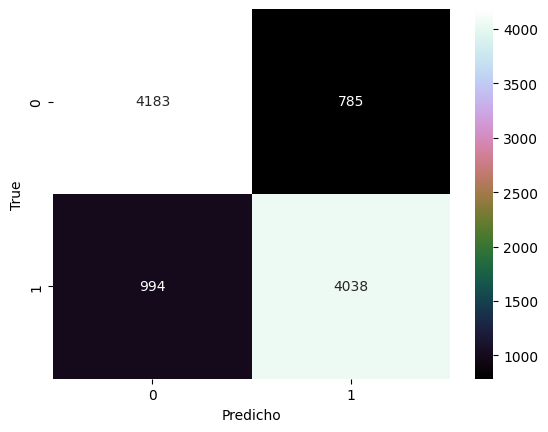

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100, random_state= 28)
random_forest.fit(x_train, y_train)
y_pred_rf_default = random_forest.predict(x_test)
imprimir_matriz_confusion(y_test, y_pred_rf_default)

In [ ]:
imprimir_metricas(y_test, y_pred_rf_default)

Metricas del modelo: 

Accuracy: 0.8221
Recall: 0.8024642289348172
F1 Score: 0.819482496194825
Precision: 0.8372382334646485


### Busqueda de Hiperparametros

In [ ]:
n = 10
params_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': list(range(50,500)),
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': list(range(1,30)),
    'max_depth': list(range(1,30))
}

folds = 5

kfoldcv = StratifiedKFold(n_splits = folds)

scorer_fn = make_scorer(f1_score, average= 'weighted')

In [ ]:
random_forest = RandomForestClassifier(random_state= 28)
rf_rs = RandomizedSearchCV(estimator = random_forest, param_distributions= params_grid, cv = kfoldcv, verbose = 3, scoring = scorer_fn)

rf_rs.fit(x_train,y_train)
rf_rs.cv_results_['mean_test_score']

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=entropy, max_depth=21, max_features=sqrt, min_samples_leaf=18, n_estimators=184;, score=0.808 total time=  19.6s
[CV 2/5] END criterion=entropy, max_depth=21, max_features=sqrt, min_samples_leaf=18, n_estimators=184;, score=0.807 total time=  19.7s
[CV 3/5] END criterion=entropy, max_depth=21, max_features=sqrt, min_samples_leaf=18, n_estimators=184;, score=0.814 total time=  19.2s
[CV 4/5] END criterion=entropy, max_depth=21, max_features=sqrt, min_samples_leaf=18, n_estimators=184;, score=0.814 total time=  18.7s
[CV 5/5] END criterion=entropy, max_depth=21, max_features=sqrt, min_samples_leaf=18, n_estimators=184;, score=0.807 total time=  18.7s
[CV 1/5] END criterion=gini, max_depth=17, max_features=sqrt, min_samples_leaf=22, n_estimators=183;, score=0.805 total time=  13.4s
[CV 2/5] END criterion=gini, max_depth=17, max_features=sqrt, min_samples_leaf=22, n_estimators=183;, score=0.806 total time= 

array([0.8099946 , 0.80717576, 0.74665244, 0.76347542, 0.80273695,
       0.806473  , 0.80915946, 0.82811475, 0.78694079, 0.81953862])

In [ ]:
best_params = rf_rs.best_params_
best_estimator = rf_rs.best_estimator_
print("Mejores Hiperparametros:", rf_rs.best_params_)
print('Mejor F1 Score: ', rf_rs.best_score_)

Mejores Hiperparametros: {'n_estimators': 376, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 22, 'criterion': 'log_loss'}
Mejor F1 Score:  0.8281147496735999


              precision    recall  f1-score   support

           0    0.83898   0.80757   0.82297      4968
           1    0.81679   0.84698   0.83161      5032

    accuracy                        0.82740     10000
   macro avg    0.82788   0.82727   0.82729     10000
weighted avg    0.82781   0.82740   0.82732     10000



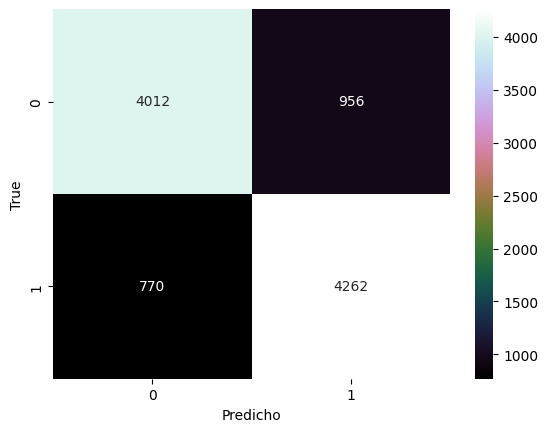

In [ ]:
y_pred_rf = best_estimator.predict(x_test)
imprimir_matriz_confusion(y_test, y_pred_rf)

In [ ]:
imprimir_metricas(y_test, y_pred_rf)

Metricas del modelo: 

Accuracy: 0.8274
Recall: 0.8469793322734499
F1 Score: 0.831609756097561
Precision: 0.8167880413951706


In [ ]:
joblib.dump(best_estimator, 'model_rf.joblib')

['model_rf.joblib']

In [ ]:
df_test['review_es'] = df_test['review_es'].apply(lambda x: preprocesamiento(x))
df_test['review_es'] = df_test['review_es'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
bag_of_words_test = vectorizer.transform(df_test['review_es'])

y_pred = rf_rs.predict(bag_of_words_test)
df_summision = pd.DataFrame({'ID':df_test['ID'], 'sentimiento': y_pred})
df_summision = df_summision.replace({'sentimiento': {1: 'positivo', 0: 'negativo'}})
df_summision.to_csv("rf.csv", index= False)
df_summision

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


## Bayes Naive (Multinomial)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(bag_of_words,
                                                    labels,
                                                    test_size= 0.2,
                                                    random_state = 28)

              precision    recall  f1-score   support

           0    0.83320   0.83655   0.83487      4968
           1    0.83799   0.83466   0.83632      5032

    accuracy                        0.83560     10000
   macro avg    0.83559   0.83561   0.83560     10000
weighted avg    0.83561   0.83560   0.83560     10000



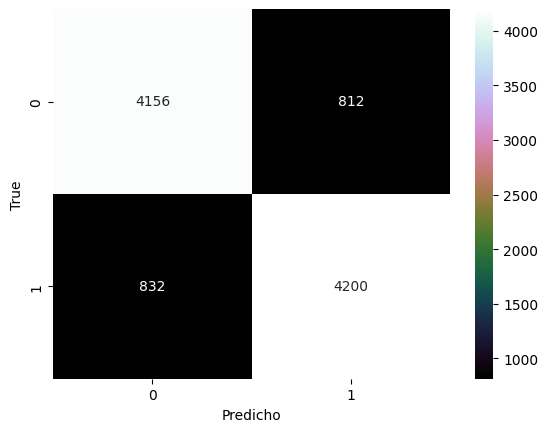

In [ ]:
bn_multinomial = MultinomialNB()
bn_multinomial.fit(x_train, y_train)
y_pred_bn_default = bn_multinomial.predict(x_test)
imprimir_matriz_confusion(y_test, y_pred_bn_default)

In [ ]:
imprimir_metricas(y_test, y_pred_bn_default)

Metricas del modelo: 

Accuracy: 0.8356
Recall: 0.834658187599364
F1 Score: 0.8363201911589009
Precision: 0.8379888268156425


### Busqueda de Hiperparametros

In [ ]:
n = 10
params_grid = {
    'alpha': np.linspace(0.1, 10, 500),
    'force_alpha': [True, False],
    'fit_prior': [True, False]
}

folds = 5

kfoldcv = StratifiedKFold(n_splits = folds)

scorer_fn = make_scorer(f1_score, average= 'weighted')

In [ ]:
bayes_multinomial = MultinomialNB()
bn_multinomial_rs = RandomizedSearchCV(estimator = bayes_multinomial, param_distributions= params_grid, cv = kfoldcv, verbose = 3, scoring = scorer_fn)

bn_multinomial_rs.fit(x_train,y_train)
bn_multinomial_rs.cv_results_['mean_test_score']

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END alpha=2.7585170340681366, fit_prior=True, force_alpha=True;, score=0.835 total time=   0.1s
[CV 2/5] END alpha=2.7585170340681366, fit_prior=True, force_alpha=True;, score=0.842 total time=   0.1s
[CV 3/5] END alpha=2.7585170340681366, fit_prior=True, force_alpha=True;, score=0.842 total time=   0.1s
[CV 4/5] END alpha=2.7585170340681366, fit_prior=True, force_alpha=True;, score=0.839 total time=   0.1s
[CV 5/5] END alpha=2.7585170340681366, fit_prior=True, force_alpha=True;, score=0.837 total time=   0.1s
[CV 1/5] END alpha=6.686773547094188, fit_prior=False, force_alpha=True;, score=0.836 total time=   0.1s
[CV 2/5] END alpha=6.686773547094188, fit_prior=False, force_alpha=True;, score=0.842 total time=   0.1s
[CV 3/5] END alpha=6.686773547094188, fit_prior=False, force_alpha=True;, score=0.842 total time=   0.1s
[CV 4/5] END alpha=6.686773547094188, fit_prior=False, force_alpha=True;, score=0.839 total time=  

array([0.83912364, 0.83952111, 0.83925454, 0.83873347, 0.83994403,
       0.83938302, 0.83828398, 0.83885962, 0.83936163, 0.8352208 ])

In [ ]:
best_params = bn_multinomial_rs.best_params_
best_estimator = bn_multinomial_rs.best_estimator_
print("Mejores Hiperparametros:", bn_multinomial_rs.best_params_)
print('Mejor F1 Score: ', bn_multinomial_rs.best_score_)

Mejores Hiperparametros: {'force_alpha': False, 'fit_prior': True, 'alpha': 5.337675350701403}
Mejor F1 Score:  0.8399440268173827


              precision    recall  f1-score   support

           0    0.82558   0.84984   0.83753      4968
           1    0.84732   0.82273   0.83485      5032

    accuracy                        0.83620     10000
   macro avg    0.83645   0.83629   0.83619     10000
weighted avg    0.83652   0.83620   0.83618     10000



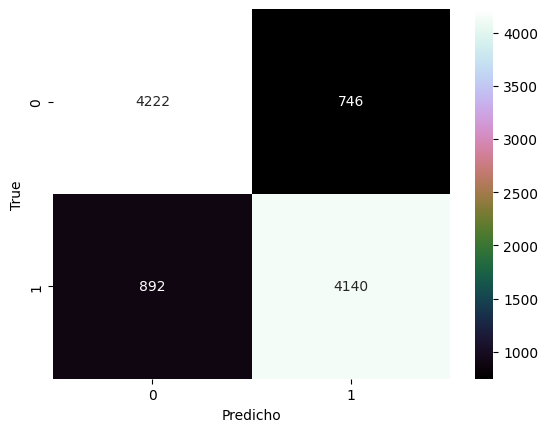

In [ ]:
y_pred_bayes_m = best_estimator.predict(x_test)
imprimir_matriz_confusion(y_test, y_pred_bayes_m)

In [ ]:
imprimir_metricas(y_test, y_pred_bayes_m)

Metricas del modelo: 

Accuracy: 0.8362
Recall: 0.8227344992050875
F1 Score: 0.8348457350272233
Precision: 0.8473188702415063


In [ ]:
joblib.dump(best_estimator, 'model_bayes_multi.joblib')

['model_bayes_multi.joblib']

In [ ]:
df_test['review_es'] = df_test['review_es'].apply(lambda x: preprocesamiento(x))
df_test['review_es'] = df_test['review_es'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
bag_of_words_test = vectorizer.transform(df_test['review_es'])

y_pred = bn_multinomial_rs.predict(bag_of_words_test)
df_summision = pd.DataFrame({'ID':df_test['ID'], 'sentimiento': y_pred})
df_summision = df_summision.replace({'sentimiento': {1: 'positivo', 0: 'negativo'}})
df_summision.to_csv("bayes_multi.csv", index= False)
df_summision

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


## Bayes Naive (Bernoulli)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(bag_of_words,
                                                    labels,
                                                    test_size= 0.2,
                                                    random_state = 28)

              precision    recall  f1-score   support

           0    0.81217   0.83816   0.82496      4968
           1    0.83501   0.80862   0.82161      5032

    accuracy                        0.82330     10000
   macro avg    0.82359   0.82339   0.82328     10000
weighted avg    0.82366   0.82330   0.82327     10000



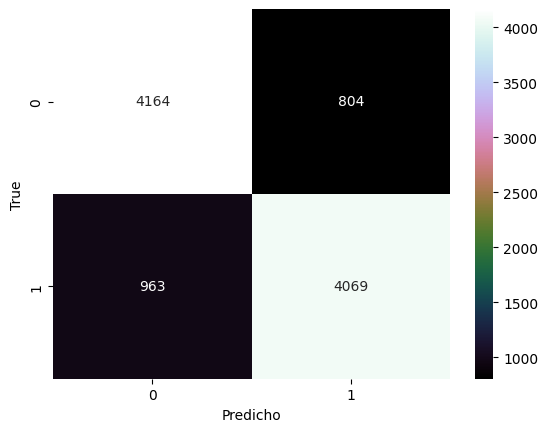

In [ ]:
bn_bernoulli = BernoulliNB()
bn_bernoulli.fit(x_train, y_train)
y_pred_bn_default = bn_bernoulli.predict(x_test)
imprimir_matriz_confusion(y_test, y_pred_bn_default)

In [ ]:
imprimir_metricas(y_test, y_pred_bn_default)

Metricas del modelo: 

Accuracy: 0.8233
Recall: 0.8086248012718601
F1 Score: 0.8216052498738012
Precision: 0.8350092345577673


### Busqueda de Hiperparametros

In [ ]:
n = 10
params_grid = {
    'alpha': np.linspace(0.1, 10, 500),
    'force_alpha': [True, False],
    'binarize': np.linspace(0, 5, 100),
    'fit_prior': [True, False]
}

folds = 5

kfoldcv = StratifiedKFold(n_splits = folds)

scorer_fn = make_scorer(f1_score, average= 'weighted')

In [ ]:
bayes_bernoulli = BernoulliNB()
bn_bernoulli_rs = RandomizedSearchCV(estimator = bayes_bernoulli, param_distributions= params_grid, cv = kfoldcv, verbose = 3, scoring = scorer_fn)

bn_bernoulli_rs.fit(x_train,y_train)
bn_bernoulli_rs.cv_results_['mean_test_score']

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END alpha=0.5761523046092185, binarize=2.8282828282828283, fit_prior=False, force_alpha=True;, score=0.334 total time=   0.1s
[CV 2/5] END alpha=0.5761523046092185, binarize=2.8282828282828283, fit_prior=False, force_alpha=True;, score=0.334 total time=   0.1s
[CV 3/5] END alpha=0.5761523046092185, binarize=2.8282828282828283, fit_prior=False, force_alpha=True;, score=0.334 total time=   0.1s
[CV 4/5] END alpha=0.5761523046092185, binarize=2.8282828282828283, fit_prior=False, force_alpha=True;, score=0.334 total time=   0.1s
[CV 5/5] END alpha=0.5761523046092185, binarize=2.8282828282828283, fit_prior=False, force_alpha=True;, score=0.334 total time=   0.1s
[CV 1/5] END alpha=3.770340681362726, binarize=0.5050505050505051, fit_prior=False, force_alpha=True;, score=0.402 total time=   0.1s
[CV 2/5] END alpha=3.770340681362726, binarize=0.5050505050505051, fit_prior=False, force_alpha=True;, score=0.399 total time=   0

array([0.3342226 , 0.40012282, 0.33583016, 0.3342226 , 0.3342226 ,
       0.3342226 , 0.43303356, 0.34006352, 0.3342226 , 0.3342226 ])

In [ ]:
best_params = bn_bernoulli_rs.best_params_
best_estimator = bn_bernoulli_rs.best_estimator_
print("Mejores Hiperparametros:", bn_bernoulli_rs.best_params_)
print('Mejor F1 Score: ', bn_bernoulli_rs.best_score_)

Mejores Hiperparametros: {'force_alpha': True, 'fit_prior': True, 'binarize': 0.45454545454545453, 'alpha': 3.4925851703406816}
Mejor F1 Score:  0.4330335634703335


              precision    recall  f1-score   support

           0    0.51287   0.95048   0.66624      4968
           1    0.68979   0.10870   0.18781      5032

    accuracy                        0.52690     10000
   macro avg    0.60133   0.52959   0.42703     10000
weighted avg    0.60189   0.52690   0.42550     10000



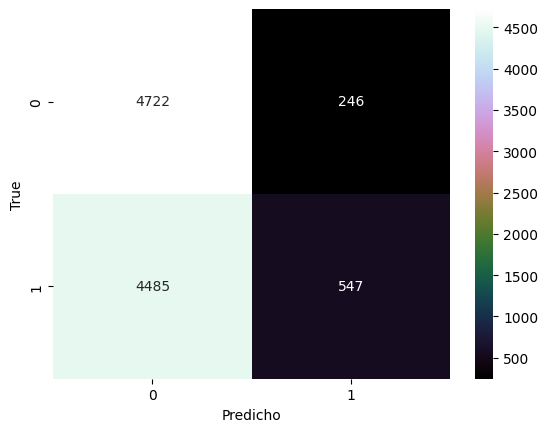

In [ ]:
y_pred_bayes_b = best_estimator.predict(x_test)
imprimir_matriz_confusion(y_test, y_pred_bayes_b)

In [ ]:
imprimir_metricas(y_test, y_pred_bayes_b)

Metricas del modelo: 

Accuracy: 0.5269
Recall: 0.10870429252782193
F1 Score: 0.18781115879828325
Precision: 0.6897856242118537


In [ ]:
df_test['review_es'] = df_test['review_es'].apply(lambda x: preprocesamiento(x))
df_test['review_es'] = df_test['review_es'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
bag_of_words_test = vectorizer.transform(df_test['review_es'])

y_pred = bn_bernoulli_rs.predict(bag_of_words_test)
df_summision = pd.DataFrame({'ID':df_test['ID'], 'sentimiento': y_pred})
df_summision = df_summision.replace({'sentimiento': {1: 'positivo', 0: 'negativo'}})
df_summision.to_csv("bayes_bernoulli.csv", index= False)
df_summision

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


## XGBoost

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(bag_of_words,
                                                    labels,
                                                    test_size= 0.2,
                                                    random_state = 28)

              precision    recall  f1-score   support

           0    0.84034   0.81260   0.82624      4968
           1    0.82082   0.84758   0.83399      5032

    accuracy                        0.83020     10000
   macro avg    0.83058   0.83009   0.83011     10000
weighted avg    0.83052   0.83020   0.83014     10000



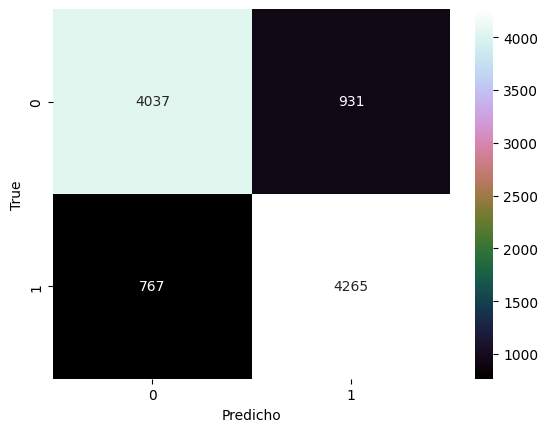

In [ ]:
xgboost_default = XGBClassifier()
xgboost_default.fit(x_train, y_train)
y_pred_xgb_default = xgboost_default.predict(x_test)
imprimir_matriz_confusion(y_test, y_pred_xgb_default)

In [ ]:
imprimir_metricas(y_test, y_pred_xgb_default)

Metricas del modelo: 

Accuracy: 0.8302
Recall: 0.8475755166931638
F1 Score: 0.8339851388345718
Precision: 0.8208237105465743


### Busqueda de Hiperparametros

In [ ]:
n = 10
params_grid = {
    'n_estimators': randint(100, 150),
    'learning_rate': uniform(0.03, 0.3),
    'max_depth': list(range(2,10)),
    'subsample': uniform(0.6, 0.4),
    #'colsample_bytree': np.array([0.5, 0.7, 0.9, 1]),
    'gamma': uniform(0, 0.5),
    #'reg_alpha': np.array([0, 10, 25, 50, 100]),
    #'reg_lambda': np.linspace(0.1, 1, 20),
}

folds = 5

kfoldcv = StratifiedKFold(n_splits = folds)

scorer_fn = make_scorer(f1_score, average= 'weighted')

In [ ]:
xgboost_m = xgb.XGBClassifier()
xgboost_rs = RandomizedSearchCV(estimator = xgboost_m, param_distributions= params_grid, cv = 5 ,n_iter= n,random_state=28, n_jobs = 1, verbose = 3, scoring = scorer_fn)

xgboost_rs.fit(x_train,y_train)
xgboost_rs.cv_results_['mean_test_score']

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END gamma=0.36450687114455954, learning_rate=0.19837188069829234, max_depth=6, n_estimators=132, subsample=0.7590369474800469;, score=0.821 total time= 2.4min
[CV 2/5] END gamma=0.36450687114455954, learning_rate=0.19837188069829234, max_depth=6, n_estimators=132, subsample=0.7590369474800469;, score=0.825 total time= 2.4min
[CV 3/5] END gamma=0.36450687114455954, learning_rate=0.19837188069829234, max_depth=6, n_estimators=132, subsample=0.7590369474800469;, score=0.832 total time= 2.4min
[CV 4/5] END gamma=0.36450687114455954, learning_rate=0.19837188069829234, max_depth=6, n_estimators=132, subsample=0.7590369474800469;, score=0.828 total time= 2.4min
[CV 5/5] END gamma=0.36450687114455954, learning_rate=0.19837188069829234, max_depth=6, n_estimators=132, subsample=0.7590369474800469;, score=0.819 total time= 2.4min
[CV 1/5] END gamma=0.39065410313673804, learning_rate=0.18329789449593392, max_depth=6, n_estimator

array([0.82488032, 0.82038453, 0.82915704, 0.76363743, 0.82597822,
       0.82706915, 0.78420641, 0.82510908, 0.8260944 , 0.79857101])

In [ ]:
best_params = xgboost_rs.best_params_
best_estimator = xgboost_rs.best_estimator_
print("Mejores Hiperparametros:", best_params)
print('Mejor F1 Score: ', xgboost_rs.best_score_)

Mejores Hiperparametros: {'gamma': 0.47768594631740463, 'learning_rate': 0.3252640404755337, 'max_depth': 6, 'n_estimators': 124, 'subsample': 0.9883180405480869}
Mejor F1 Score:  0.829157039662167


              precision    recall  f1-score   support

           0    0.84483   0.81320   0.82872      4968
           1    0.82215   0.85254   0.83707      5032

    accuracy                        0.83300     10000
   macro avg    0.83349   0.83287   0.83290     10000
weighted avg    0.83342   0.83300   0.83292     10000



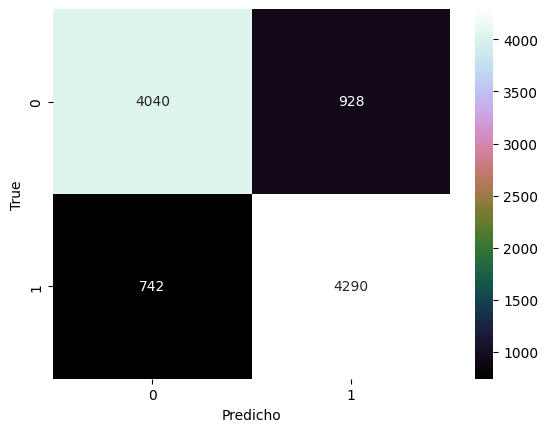

In [ ]:
y_pred_xgb = best_estimator.predict(x_test)
imprimir_matriz_confusion(y_test, y_pred_xgb)

In [ ]:
imprimir_metricas(y_test, y_pred_xgb)

Metricas del modelo: 

Accuracy: 0.833
Recall: 0.8525437201907791
F1 Score: 0.8370731707317075
Precision: 0.8221540820237639


In [ ]:
joblib.dump(best_estimator, 'model_xgb.joblib')

['model_xgb.joblib']

In [ ]:
df_test['review_es'] = df_test['review_es'].apply(lambda x: preprocesamiento(x))
df_test['review_es'] = df_test['review_es'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
bag_of_words_test = vectorizer.transform(df_test['review_es'])

y_pred = xgboost_rs.predict(bag_of_words_test)
df_summision = pd.DataFrame({'ID':df_test['ID'], 'sentimiento': y_pred})
df_summision = df_summision.replace({'sentimiento': {1: 'positivo', 0: 'negativo'}})
df_summision.to_csv("xgboost.csv", index= False)
df_summision

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


## Ensambles

In [67]:
x_train, x_test, y_train, y_test = train_test_split(bag_of_words,
                                                    labels,
                                                    test_size= 0.2,
                                                    random_state = 28)

In [ ]:
from itertools import combinations
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegressionCV

### Stacking

In [ ]:
def evaluate_model(model, x, y):
  cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state = 28)
  scores = cross_val_score(model, bag_of_words, labels, scoring = 'f1', cv = cv, verbose = 3, n_jobs =-1, error_score = 'raise')
  return scores

In [49]:
base_models = [
    ('random_forest', RandomForestClassifier(n_estimators = 376, min_samples_leaf = 1, max_features = 'log2', max_depth=22, criterion = 'log_loss')),
    ('bayes_multi', MultinomialNB(alpha = 4.067935871, force_alpha = True, fit_prior = False)),
    ('xgb_boost', XGBClassifier(gamma = 0.4776859, learning_rate = 0.325264, max_depth = 6, n_estimators = 124, subsample = 0.98831804))
]

meta_model = LogisticRegressionCV()

stacking_model = StackingClassifier(estimators = base_models,
                                    final_estimator = meta_model,
                                    passthrough = True,
                                    cv = 2,
                                    verbose = 3)
stacking_scores = evaluate_model(stacking_model, x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 146.2min finished


In [50]:
stacking_model.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

StackingClassifier(cv=2,
                   estimators=[('random_forest',
                                RandomForestClassifier(criterion='log_loss',
                                                       max_depth=22,
                                                       max_features='log2',
                                                       n_estimators=376)),
                               ('bayes_multi',
                                MultinomialNB(alpha=4.067935871,
                                              fit_prior=False,
                                              force_alpha=True)),
                               ('xgb_boost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              col...
                                              learning_rate=0.325264,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=124, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=LogisticRegressionCV(), passthrough=True,
                   verbose=3)

              precision    recall  f1-score   support

           0    0.87836   0.85467   0.86635      4968
           1    0.86024   0.88315   0.87154      5032

    accuracy                        0.86900     10000
   macro avg    0.86930   0.86891   0.86895     10000
weighted avg    0.86924   0.86900   0.86897     10000



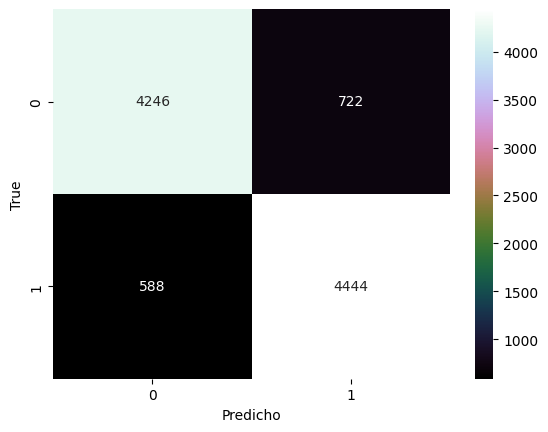

In [51]:
y_pred_stack = stacking_model.predict(x_test)
imprimir_matriz_confusion(y_test, y_pred_stack)

In [52]:
imprimir_metricas(y_test, y_pred_stack)

Metricas del modelo: 

Accuracy: 0.869
Recall: 0.8831478537360891
F1 Score: 0.8715434398901747
Precision: 0.8602400309717383


In [53]:
joblib.dump(stacking_model, 'stacking.joblib')

['stacking.joblib']

In [54]:
df_test['review_es'] = df_test['review_es'].apply(lambda x: preprocesamiento(x))
df_test['review_es'] = df_test['review_es'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
bag_of_words_test = vectorizer.transform(df_test['review_es'])

y_pred = stacking_model.predict(bag_of_words_test)
df_summision = pd.DataFrame({'ID':df_test['ID'], 'sentimiento': y_pred})
df_summision = df_summision.replace({'sentimiento': {1: 'positivo', 0: 'negativo'}})
df_summision.to_csv("stacking.csv", index= False)
df_summision

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,positivo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


### Voting

In [59]:
model_xgb = joblib.load('/content/model_xgb.joblib')
model_bayes_multi = joblib.load('/content/model_bayes_multi_4.joblib')
model_random_forest = joblib.load('/content/model_rf_6.joblib')

estimator = [('xgb_cl', model_xgb), ('bayes_m', model_bayes_multi), ('rf', model_random_forest)]

In [61]:
voting_model = VotingClassifier(estimators = estimator, voting = 'soft')

In [62]:
voting_model.fit(x_train, y_train)

VotingClassifier(estimators=[('xgb_cl',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=0.47768594631740463,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraint...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=124, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('bayes_m',
                              MultinomialNB(alpha=4.0679358717434875,
                                            fit_prior=False,
                                            force_alpha=True)),
                             ('rf',
                              RandomForestClassifier(criterion='log_loss',
                                                     max_depth=22,
                                                     max_features='log2',
                                                     n_estimators=376,
                                                     random_state=28))],
                 voting='soft')

              precision    recall  f1-score   support

           0    0.86016   0.84440   0.85221      4968
           1    0.84911   0.86447   0.85672      5032

    accuracy                        0.85450     10000
   macro avg    0.85464   0.85444   0.85447     10000
weighted avg    0.85460   0.85450   0.85448     10000



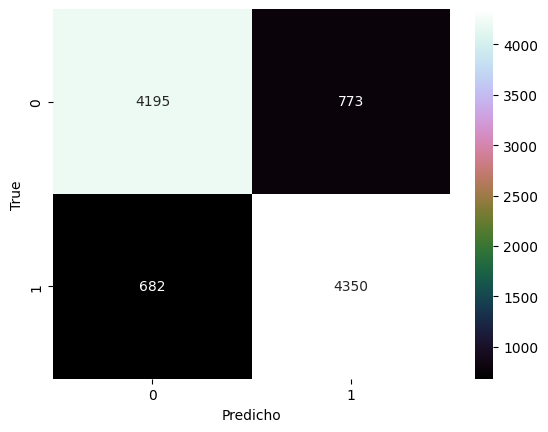

In [63]:
y_pred_voting = voting_model.predict(x_test)
imprimir_matriz_confusion(y_test, y_pred_voting)

In [64]:
imprimir_metricas(y_test, y_pred_voting)

Metricas del modelo: 

Accuracy: 0.8545
Recall: 0.8644674085850557
F1 Score: 0.8567208271787297
Precision: 0.8491118485262541


In [65]:
joblib.dump(voting_model, 'voting.joblib')

['voting.joblib']

In [66]:
df_test['review_es'] = df_test['review_es'].apply(lambda x: preprocesamiento(x))
df_test['review_es'] = df_test['review_es'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
bag_of_words_test = vectorizer.transform(df_test['review_es'])

y_pred = voting_model.predict(bag_of_words_test)
df_summision = pd.DataFrame({'ID':df_test['ID'], 'sentimiento': y_pred})
df_summision = df_summision.replace({'sentimiento': {1: 'positivo', 0: 'negativo'}})
df_summision.to_csv("voting.csv", index= False)
df_summision

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo
